# Modeling

Here we'll build a computer vision model to detect if a lung disease is present or not.

## Data Loading

PyTorch works better with classes, so first let's define a class to load in our data during training. Also, we'll just use the data from one folder for now to make things simple as the focus is more so on building a proof of concept user facing app at the moment, rather than the best model.

In [14]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split

# Define the dataset class
class LungDiseaseDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['image_index'])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx]['finding_labels']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
df = pd.read_csv("../data/lung_disease_labels.csv")
img_dir = "D:\BigData\images_005\images"

Now our dataframe has the file names and labels from all the images folders, but since we are just using one for now, we need to access only those - i.e. get the relevant subset.

In [2]:
def get_image_files(index_lst: list):
    image_files = []

    for i in index_lst:
        image_dir = f"D:\BigData\images_00{i}\images"
        
        image_files_for_one_folder = os.listdir(image_dir)
        
        image_files += image_files_for_one_folder
        
    return image_files

image_files = get_image_files([5])
len(image_files)

10000

You can double check it worked here by inspecting the first few elements.

In [3]:
image_files[0:5]

['00009232_004.png',
 '00009232_005.png',
 '00009232_006.png',
 '00009232_007.png',
 '00009233_000.png']

Now get the subset.

In [4]:
subset_df = df[df["image_index"].isin(image_files)]
subset_df.shape

(10000, 6)

Remember from the previous notebook we want a ratio of around 1.16 in the binary target variable, to reflect the total dataset distribution.

In [5]:
subset_df["finding_labels"].value_counts()[0] / subset_df["finding_labels"].value_counts()[1]

1.2070183182520415

## Data Processing

Split the data into training and testing sets. The testing set here is just the validation set. Since we have plenty of other images in the other folders, we can use them for testing at inference time.

In [6]:
train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=42)

Now we need our transformations. The main thing to do here is resize the images so it's more manageble, but we can come back here and play with transformations later on too.

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = LungDiseaseDataset(train_df, img_dir, transform=transform)
val_dataset = LungDiseaseDataset(val_df, img_dir, transform=transform)

Note the number of workers must be zero to work depending on hardware resources - otherwise you'll get stuck in an endless runtime.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

This is just to make sure the DataLoader works as intended.

In [9]:
import time

start_time = time.time()

# Test loading one batch from train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

end_time = time.time()
print(f"Time to load one batch: {end_time - start_time:.2f} seconds")


Time to load one batch: 0.70 seconds


Now we get into model training. We'll use the resnet pretrained model.

In [16]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_start_time = time.time()

    for i, (images, labels) in enumerate(train_loader):
        batch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Batch [{i+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, "
                  f"Batch Time: {time.time() - batch_start_time:.2f}s")
            
    epoch_loss = running_loss / len(train_loader)
    epoch_time = time.time() - epoch_start_time
    
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, "
        f"Average Loss: {epoch_loss:.4f}, "
        f"Epoch Time: {epoch_time:.2f}s")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs.squeeze(), labels).item()
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 10 == 0:  # Print every 10 batches
                print(f"Validation Batch [{i+1}/{len(val_loader)}] processed")
            
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {loss.item():.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {100 * correct / total:.2f}%")
    
    

Epoch [1/10], Batch [10/250], Loss: 0.7285, Batch Time: 0.20s
Epoch [1/10], Batch [20/250], Loss: 0.6641, Batch Time: 0.19s
Epoch [1/10], Batch [30/250], Loss: 0.6733, Batch Time: 0.18s
Epoch [1/10], Batch [40/250], Loss: 0.7189, Batch Time: 0.18s
Epoch [1/10], Batch [50/250], Loss: 0.7792, Batch Time: 0.18s
Epoch [1/10], Batch [60/250], Loss: 0.5991, Batch Time: 0.18s
Epoch [1/10], Batch [70/250], Loss: 0.5532, Batch Time: 0.18s
Epoch [1/10], Batch [80/250], Loss: 0.5815, Batch Time: 0.19s
Epoch [1/10], Batch [90/250], Loss: 0.6574, Batch Time: 0.19s
Epoch [1/10], Batch [100/250], Loss: 0.6953, Batch Time: 0.19s
Epoch [1/10], Batch [110/250], Loss: 0.5654, Batch Time: 0.18s
Epoch [1/10], Batch [120/250], Loss: 0.6014, Batch Time: 0.19s
Epoch [1/10], Batch [130/250], Loss: 0.6241, Batch Time: 0.18s
Epoch [1/10], Batch [140/250], Loss: 0.6988, Batch Time: 0.18s
Epoch [1/10], Batch [150/250], Loss: 0.6880, Batch Time: 0.18s
Epoch [1/10], Batch [160/250], Loss: 0.5929, Batch Time: 0.19s
E

In [17]:
# Optionally, save the entire model (including architecture)
full_model_save_path = 'lung_disease_model_full.pth'
torch.save(model, full_model_save_path)
print(f"Full model saved to {full_model_save_path}")

# Save the best model based on validation accuracy
best_model_path = 'lung_disease_model_best.pth'
best_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_accuracy) + 1
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'accuracy': best_accuracy,
}, best_model_path)
print(f"Best model (epoch {best_epoch}, accuracy {best_accuracy:.2f}%) saved to {best_model_path}")

Full model saved to lung_disease_model_full.pth
Best model (epoch 7, accuracy 70.75%) saved to lung_disease_model_best.pth


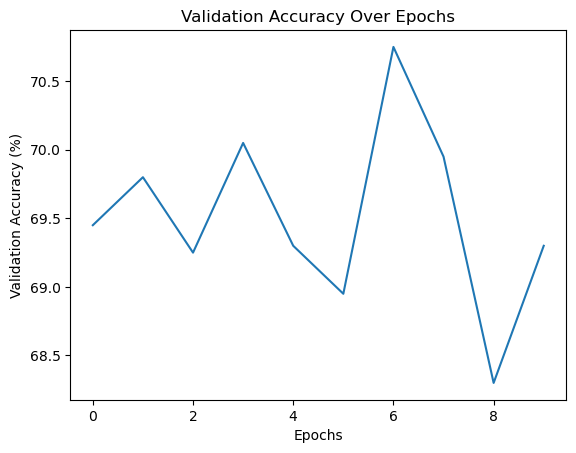

In [18]:
import matplotlib.pyplot as plt

plt.plot(val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.show()


So it looks like the model isn't really changing much during the epochs. 1 epoch is probably fine.

In [20]:
from sklearn.metrics import recall_score

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")



Recall: 0.50


And recall isn't great. The training code works as intended though so we can modularize it and work on getting better scores later on.

# Inference

First let's load the model we saved.

In [1]:
import torch
import torchvision.models as models

In [2]:
model = torch.load('lung_disease_model_full.pth')
model.eval()

C:\Users\RaviB\AppData\Local\Temp\ipykernel_26040\3717321768.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('lung_disease_model_full.pth')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
best_model = models.resnet50(pretrained=False)
num_ftrs = best_model.fc.in_features
best_model.fc = torch.nn.Linear(num_ftrs, 1)  # Binary classification

checkpoint = torch.load('lung_disease_model_best.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

c:\Users\RaviB\anaconda3\envs\healthscan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\RaviB\anaconda3\envs\healthscan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\RaviB\AppData\Local\Temp\ipykernel_26040\1830528243.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Now let's load an image from a random other folder, preprocess it in the same way, and then predict if a desease is present or not.

In [6]:
import os

def get_image_files(index_lst: list):
    image_files = []

    for i in index_lst:
        image_dir = f"D:\BigData\images_00{i}\images"
        
        image_files_for_one_folder = os.listdir(image_dir)
        
        image_files += image_files_for_one_folder
        
    return image_files

image_files = get_image_files([6])

In [17]:
test_images = image_files[0:5]

In [12]:
#from PIL import image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
test_df = df[df["image_index"].isin(test_images)]

img_dir = "D:\BigData\images_006\images"
test_images_dataset = LungDiseaseDataset(test_df, img_dir, transform=transform)

for i in range(0, 5):
    image, _ = test_images_dataset[i]

    # Add batch dimension and move to device
    input_tensor = image.unsqueeze(0).to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probability = torch.sigmoid(output).item()

    # Interpret the result
    prediction = "Disease detected" if probability > 0.5 else "No disease detected"
    print(f"Prediction: {prediction}")
    print(f"Probability of disease: {probability:.2f}")
    print("\n")

Prediction: No disease detected
Probability of disease: 0.43


Prediction: No disease detected
Probability of disease: 0.34


Prediction: No disease detected
Probability of disease: 0.28


Prediction: Disease detected
Probability of disease: 0.61


Prediction: No disease detected
Probability of disease: 0.24




So the next model that we would make is to predict which disease is present, if one is detected. For now though, we are just going to create a placeholder function for this model to demonstrate the full functionality in a web app.

In [32]:
import random

def detect_which_disease_placeholder():
    return random.choice([
        'Infiltration',
        'Effusion',
        'Atelectasis',
        'Nodule',
        'Mass',
        'Pneumothorax',
        'Consolidation',
        'Pleural_Thickening',
        'Cardiomegaly',
        'Emphysema',
        'Edema',
        'Fibrosis',
        'Pneumonia',
        'Hernia'
    ])

In [33]:
print(detect_which_disease_placeholder())

Pneumonia
